🍎 計算グラフ結果
合計価格: 715.0000000000001
dApple: 2.2 dApple_num: 110.00000000000001
dOrange: 3.3000000000000003 dOrange_num: 165.0
dTax: 650

📉 勾配確認：数値微分 vs 誤差逆伝播
W1: 差の平均 = 0.000001
b1: 差の平均 = 0.000006
W2: 差の平均 = 0.000000
b2: 差の平均 = 0.000000

📈 学習完了。最終損失: 0.1386794674963564


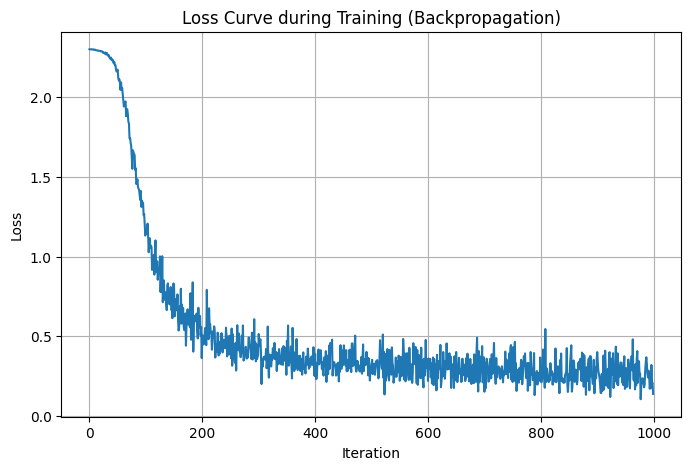

In [7]:
# coding: utf-8

# -------------------------
# 1. 計算グラフの確認
# -------------------------
from layer_naive import MulLayer, AddLayer

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# Layerの構成
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_fruit_layer = AddLayer()
mul_tax_layer = MulLayer()

# 順伝播
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
fruit_price = add_fruit_layer.forward(apple_price, orange_price)
total_price = mul_tax_layer.forward(fruit_price, tax)

# 逆伝播
dprice = 1
dfruit_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_fruit_layer.backward(dfruit_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print("🍎 計算グラフ結果")
print("合計価格:", total_price)
print("dApple:", dapple, "dApple_num:", dapple_num)
print("dOrange:", dorange, "dOrange_num:", dorange_num)
print("dTax:", dtax)

# -------------------------
# 2. 勾配確認（gradient check）
# -------------------------
import numpy as np
import sys, os

sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), _ = load_mnist(normalize=True, one_hot_label=True)
x_batch = x_train[:3]
t_batch = t_train[:3]

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

print("\n📉 勾配確認：数値微分 vs 誤差逆伝播")
for key in grad_numerical.keys():
    diff = np.mean(np.abs(grad_numerical[key] - grad_backprop[key]))
    print(f"{key}: 差の平均 = {diff:.6f}")

# -------------------------
# 3. 学習ループ
# -------------------------
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

print("\n📈 学習完了。最終損失:", train_loss_list[-1])

# -------------------------
# 4. 可視化（学習曲線）
# -------------------------
import matplotlib.pyplot as plt

# -------------------------
# 4. 可視化（学習曲線）
# -------------------------
import matplotlib.pyplot as plt

from matplotlib import rcParams

rcParams["font.family"] = (
    "DejaVu Sans"  # 標準的な英語フォント（特に指定不要な場合もあり）
)

plt.figure(figsize=(8, 5))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve during Training (Backpropagation)")
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

Config: []
  Trial: 1
  Trial: 2
  Trial: 3
  Trial: 4
  Trial: 5
  Trial: 6
  Trial: 7
  Trial: 8
  Trial: 9
  Trial: 10
Config: [50]
  Trial: 1
  Trial: 2
  Trial: 3
  Trial: 4
  Trial: 5
  Trial: 6
  Trial: 7
  Trial: 8
  Trial: 9
  Trial: 10
Config: [100]
  Trial: 1
  Trial: 2
  Trial: 3
  Trial: 4
  Trial: 5
  Trial: 6
  Trial: 7
  Trial: 8
  Trial: 9
  Trial: 10
Config: [100, 100]
  Trial: 1
  Trial: 2
  Trial: 3
  Trial: 4
  Trial: 5
  Trial: 6
  Trial: 7
  Trial: 8
  Trial: 9
  Trial: 10
Config: [100, 100, 100]
  Trial: 1
  Trial: 2
  Trial: 3
  Trial: 4
  Trial: 5
  Trial: 6
  Trial: 7
  Trial: 8
  Trial: 9
  Trial: 10
Config: [200, 200, 200]
  Trial: 1
  Trial: 2
  Trial: 3
  Trial: 4
  Trial: 5
  Trial: 6
  Trial: 7
  Trial: 8
  Trial: 9
  Trial: 10


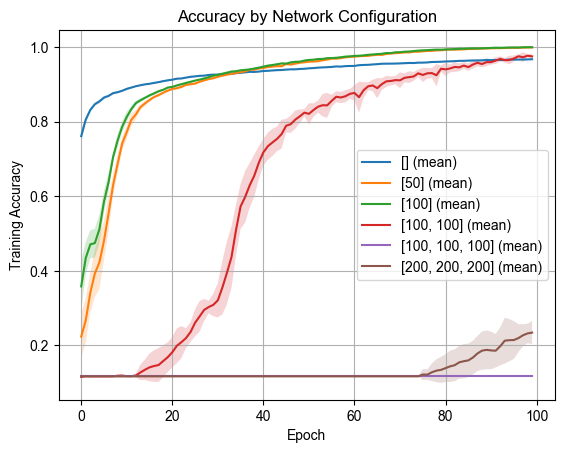

In [ ]:
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

np.random.seed(42)  # 好きな整数を指定（例：42）

# matplotlib: English only
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial"]

from dataset.mnist import load_mnist
from common.functions import *
from common.layers import *


class DynamicNet:
    def __init__(self, input_size, hidden_sizes, output_size, weight_init_std=0.01):
        self.params = {}
        self.layers = []
        self.hidden_sizes = hidden_sizes
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]

        for idx in range(len(self.layer_sizes) - 1):
            i, o = self.layer_sizes[idx], self.layer_sizes[idx + 1]
            self.params[f"W{idx+1}"] = weight_init_std * np.random.randn(i, o)
            self.params[f"b{idx+1}"] = np.zeros(o)

        self.layers = []
        for idx in range(len(self.layer_sizes) - 2):
            self.layers.append(
                Affine(self.params[f"W{idx+1}"], self.params[f"b{idx+1}"])
            )
            self.layers.append(Relu())
        last_idx = len(self.layer_sizes) - 2
        self.layers.append(
            Affine(self.params[f"W{last_idx+1}"], self.params[f"b{last_idx+1}"])
        )

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = self.layers[::-1]
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for idx in range(len(self.layer_sizes) - 1):
            grads[f"W{idx+1}"] = self.layers[2 * idx].dW
            grads[f"b{idx+1}"] = self.layers[2 * idx].db

        return grads


def run_experiment(
    hidden_configs, train_size=500, max_epochs=100, learning_rate=0.001, repeat=10
):
    (x_train, t_train), (x_test, t_test) = load_mnist(
        normalize=True, one_hot_label=True
    )
    x_train, t_train = x_train[:train_size], t_train[:train_size]

    batch_size = 100
    stats = defaultdict(list)

    for config in hidden_configs:
        print(f"Config: {config}")
        for trial in range(repeat):
            print(f"  Trial: {trial + 1}")
            network = DynamicNet(784, config, 10)
            train_acc_list = []

            for epoch in range(max_epochs):
                perm = np.random.permutation(train_size)
                x_train_shuffled = x_train[perm]
                t_train_shuffled = t_train[perm]

                for i in range(0, train_size, batch_size):
                    x_batch = x_train_shuffled[i : i + batch_size]
                    t_batch = t_train_shuffled[i : i + batch_size]

                    grads = network.gradient(x_batch, t_batch)

                    for key in grads.keys():
                        network.params[key] -= learning_rate * grads[key]

                acc = network.accuracy(x_train, t_train)
                train_acc_list.append(acc)

            stats[str(config)].append(train_acc_list)

    return stats


def plot_stats(stats):
    for key, acc_lists in stats.items():
        acc_lists = np.array(acc_lists)７
        mean_acc = np.mean(acc_lists, axis=0)
        std_acc = np.std(acc_lists, axis=0)
        epochs = np.arange(len(mean_acc))

        plt.plot(epochs, mean_acc, label=f"{key} (mean)")
        plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.title("Accuracy by Network Configuration")
    plt.legend()
    plt.grid(True)
    plt.show()


# Run
hidden_layer_sets = [
    [],
    [50],
    [100],
    [100, 100],
    [100, 100, 100],
    [200, 200, 200],
]

stats = run_experiment(
    hidden_layer_sets, train_size=1000, max_epochs=100, learning_rate=0.1, repeat=10
)
plot_stats(stats)